The following code starts the multi client script in the background and records load balancer metrics at regular intervals to analyse. In this first example the load balancer is using the round robin algorithm.

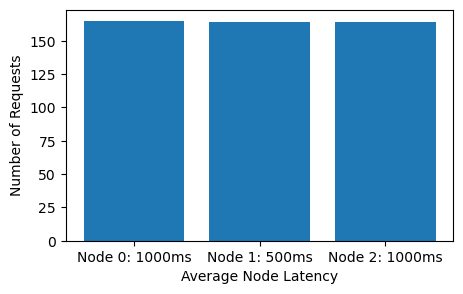

Average Overall Latency: 833ms


<Figure size 500x300 with 0 Axes>

In [84]:
import collections
import requests
import subprocess
import sys
import time

from IPython.display import clear_output, display
import matplotlib
import matplotlib.pyplot as plt

LB_URL = "http://localhost:8080"
REQUEST_COUNT = 100
CLIENT_COUNT = 5
METRICS_BUFFER_MAXLEN = 30
METRIC_INTERVAL = 5

# Store most recent metrics
metrics_buffer: collections.deque

# Setup figure and axis
plt.rcParams["figure.figsize"] = [5, 3]
plt.tight_layout()
figure, axis = plt.subplots(nrows=1, ncols=1)

def update_metrics_buffer():
    """Update metrics values in metrics buffer."""
    
    # Run multi client script in background process
    multi_client_process = subprocess.Popen(["go", "run", "../demo/multi-client/", LB_URL, str(REQUEST_COUNT), str(CLIENT_COUNT)],
                                            stdout=sys.stdout)
    print("Multi client simulation started. See Jupyter's stdout for logs")
    
    global metrics_buffer
    if metrics_buffer is None:
        metrics_buffer = collections.deque(maxlen=METRICS_BUFFER_MAXLEN)
    else:
        metrics_buffer.clear()
    
    # While multi client script process is still running
    print("Started fetching metrics at a regular interval")
    while multi_client_process.poll() is None:
        
        # Fetch metrics
        response = requests.get(LB_URL + "/metrics")
    
        # Save metric data
        metrics_buffer.append(response.json())
    
        time.sleep(METRIC_INTERVAL)
    
    print("Multi client simulation finished")

def plot_request_count_bar_chart(axes: matplotlib.axes.Axes):
    """Plot request count bar chart.

    Args:
        axes (plt.axes.Axes): The axes object to plot to.
    
    """
    average_node_latencies = [f"Node {i}: {server_node_metric['averageLatency']}" for i, server_node_metric in enumerate(metrics_buffer[-1]["serverNodeMetrics"])]
    request_counts = [server_node_metric["requestCount"] for server_node_metric in metrics_buffer[-1]["serverNodeMetrics"]]

    axes.clear()
    axes.set_xlabel("Average Node Latency")
    axes.set_ylabel("Number of Requests")
    axes.bar(average_node_latencies, request_counts)

update_metrics_buffer()
plot_request_count_bar_chart(axis)

clear_output()
display(figure)
plt.close(figure)

print(f"Average Overall Latency: {metrics_buffer[-1]['overallLatency']}")


In this next example the load balancer is using the weighted round robin algorithm with weights inversely proportional to each server's simulated latency.

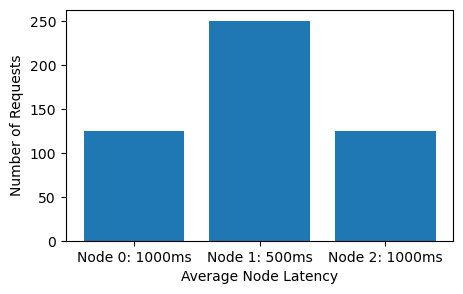

Average Overall Latency: 750ms


In [85]:
update_metrics_buffer()
plot_request_count_bar_chart(axis)

clear_output()
display(figure)
plt.close(figure)

print(f"Average Overall Latency: {metrics_buffer[-1]['overallLatency']}")